In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline

# Reading Files

In [29]:
# df1 = df1.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)
# df2 = df2.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)
# df1 = pd.read_csv('train_data.csv')
# df2 = pd.read_csv('train_data_merged.csv')
df = pd.read_csv('../data/processedData/training_data.csv')
df = df.drop(['LOG_ID', 'PAT_ID', 'MRN'], axis=1)
# print(df3)

In [30]:
# X = df1.drop('Cardiovascular', axis=1)  
# y = df1['Cardiovascular']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# svm_model = SVC()

# svm_model.fit(X_train_scaled, y_train)

# y_pred = svm_model.predict(X_test_scaled)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='binary') 
# recall = recall_score(y_test, y_pred, average='binary')

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")

In [31]:
# X = df2.drop('Cardiovascular', axis=1)
# y = df2['Cardiovascular']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# svm_model = SVC()

# svm_model.fit(X_train_scaled, y_train)

# y_pred = svm_model.predict(X_test_scaled)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='binary')
# recall = recall_score(y_test, y_pred, average='binary')

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")

In [32]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, precision_score, recall_score
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# X = df2.drop('Cardiovascular', axis=1)  
# y = df2['Cardiovascular']  

# accuracy_list = []
# precision_list = []
# recall_list = []

# scaler = StandardScaler()

# for i in range(20):
#     X_train, _, y_train, _ = train_test_split(X, y, train_size=19/20, random_state=i)
    
   
#     smote = SMOTE(sampling_strategy=1, random_state=i) 
    
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
#     X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
#     X_test_scaled = scaler.transform(X) 
    
#     svm_model = SVC()
#     svm_model.fit(X_train_resampled_scaled, y_train_resampled)
    
#     y_pred = svm_model.predict(X_test_scaled)
    
#     accuracy = accuracy_score(y, y_pred)
#     precision = precision_score(y, y_pred, average='binary')
#     recall = recall_score(y, y_pred, average='binary')
    
#     accuracy_list.append(accuracy)
#     precision_list.append(precision)
#     recall_list.append(recall)

# print(f"Accuracy: {np.mean(accuracy_list)}")
# print(f"Precision: {np.mean(precision_list)}")
# print(f"Recall: {np.mean(recall_list)}")

# Model Fitting

In [33]:
X = df.drop('Cardiovascular', axis=1) 
y = df['Cardiovascular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC()

svm_model.fit(X_train_scaled, y_train)

y_pred = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.8879668049792531
Precision: 0.922077922077922
Recall: 0.5966386554621849


In [34]:
# svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

# cv_scores = cross_val_score(svm_model, X, y, cv=20, scoring='precision')

# print(f'20-fold Cross-Validation precision Scores: {cv_scores}')

# print(f'Mean precision: {cv_scores.mean()}')
# print(f'Standard Deviation: {cv_scores.std()}')

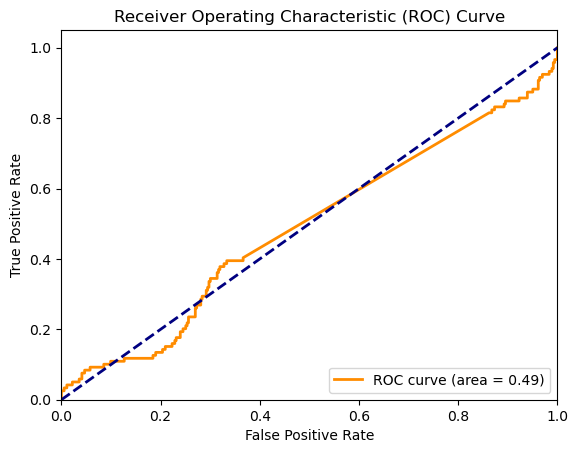

In [35]:
X = df.drop('Cardiovascular', axis=1) 
y = df['Cardiovascular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_model = SVC(kernel='rbf', probability=True) 

svm_model.fit(X_train, y_train)

y_score = svm_model.predict_proba(X_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

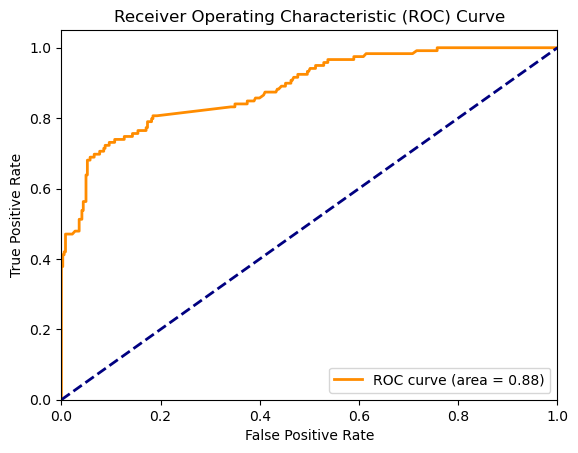

In [36]:
X = df.drop('Cardiovascular', axis=1) 
y = df['Cardiovascular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

selector = SelectKBest(f_classif, k=10)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [X.columns[i] for i in selected_feature_indices]
svm_model = SVC(kernel='rbf', probability=True)

svm_model.fit(X_train_new, y_train)

y_score = svm_model.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:
# print(f"selected features: {selected_feature_names}")

In [41]:
X = df.drop('Cardiovascular', axis=1) 
y = df['Cardiovascular']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

svm_l1 = LinearSVC(penalty='l1', dual=False, max_iter=10000)
svm_l1.fit(X_scaled, y)

selected_features = np.where(np.abs(svm_l1.coef_) >0.1)[1]
selected_feature_names = X.columns[selected_features]
print("Selected significant features:", selected_feature_names)

print("Coefficients of selected features:", svm_l1.coef_[:, selected_features])

Selected significant features: Index(['LOS', 'ASA_RATING_C', 'qrs_freq_power', 'vt_freq_power',
       'Erythrocyte distribution width',
       'Erythrocyte mean corpuscular hemoglobin',
       'Erythrocyte mean corpuscular hemoglobin concentration', 'Erythrocytes',
       'Hematocrit'],
      dtype='object')
Coefficients of selected features: [[ 0.18971949  0.12355068  0.16825269 -0.13859917  0.23261967 -0.14166088
   0.1892137   0.26695666 -0.20837501]]


In [42]:
scoring = ['precision', 'accuracy', 'recall']

X_array = X.values
X_selected = X_array[:, selected_features]
y = df3['Cardiovascular']
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

cv_scores =cross_validate(svm_model, X_selected, y, cv=20, scoring=scoring)

precision_mean = np.mean(cv_scores['test_precision'])
accuracy_mean = np.mean(cv_scores['test_accuracy'])
recall_mean = np.mean(cv_scores['test_recall'])

print(f"Average Precision: {precision_mean}")
print(f"Average Accuracy: {accuracy_mean}")
print(f"Average Recall: {recall_mean}")

Average Precision: 0.8199749811591918
Average Accuracy: 0.8627160493827162
Average Recall: 0.5828947368421054
